Import libraries

In [65]:
import os 
import math
import pickle
import random
import json
import numpy as np
from tqdm import tqdm
from pprint import pprint 
from molmass import Formula
import rdkit.Chem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from msbuddy.utils import read_formula_str

import pandas as pd
from scipy.stats import pearsonr

import scipy.stats as stats
import matplotlib.pyplot as plt

from matchms import Spectrum
from matchms import calculate_scores
from matchms.similarity import CosineGreedy

Helper function

In [3]:
def load_pickle(path):

    with open(path, "rb") as f:
        return pickle.load(f)

In [50]:
def find_match(mz, current_dict, threshold = 0.01):

    current_keys = list(current_dict.keys())
    matches = [(k, abs(mz-k)) for k in current_keys if abs(mz-k) <= threshold]
    if len(matches) == 0: return (False, None)
    
    best_match = sorted(matches, key = lambda x: x[1])[0]
    return (True, best_match[0])

In [51]:
def group_peaks(mz_list, intensity_list):

    grouped_peaks = {}

    for mz, intensity in list(zip(mz_list, intensity_list)):

        mz = np.round(mz, 2)
        match, key = find_match(mz, grouped_peaks)
        if not match:
            grouped_peaks[mz] = {"mz_list": [mz],
                                 "intensity_list": [intensity]}
        
        else:
            # Add to the mz list 
            grouped_peaks[key]["mz_list"].append(mz)
            grouped_peaks[key]["intensity_list"].append(intensity)

    pprint(grouped_peaks)

    print()
    a = z 
    


In [52]:
group_peaks(rec.mz, rec.intensities)

{51.02: {'intensity_list': [0.010254190000000002], 'mz_list': [51.02]},
 53.0: {'intensity_list': [0.00440113], 'mz_list': [53.0]},
 53.04: {'intensity_list': [0.04250554], 'mz_list': [53.04]},
 55.02: {'intensity_list': [0.030444460000000003], 'mz_list': [55.02]},
 55.05: {'intensity_list': [0.17937624], 'mz_list': [55.05]},
 58.03: {'intensity_list': [0.07494156], 'mz_list': [58.03]},
 65.04: {'intensity_list': [0.05608448], 'mz_list': [65.04]},
 67.05: {'intensity_list': [0.15531606], 'mz_list': [67.05]},
 77.04: {'intensity_list': [0.055034200000000005], 'mz_list': [77.04]},
 79.05: {'intensity_list': [0.01214707], 'mz_list': [79.05]},
 81.03: {'intensity_list': [0.01530992], 'mz_list': [81.03]},
 81.07: {'intensity_list': [0.00289825], 'mz_list': [81.07]},
 91.05: {'intensity_list': [0.24919526], 'mz_list': [91.05]},
 93.03: {'intensity_list': [0.00515459], 'mz_list': [93.03]},
 94.04: {'intensity_list': [0.00475934], 'mz_list': [94.04]},
 95.05: {'intensity_list': [0.24722024], '

NameError: name 'z' is not defined

Get the data

In [7]:
folder = "/data/rbg/users/klingmin/projects/MS_processing/benchmarks/massspec_gym/noisy_lookup"
DB = load_pickle(os.path.join(folder, "DB.pkl"))
noisy_set = load_pickle(os.path.join(folder, "noisy_set.pkl"))

greedy_cs = CosineGreedy()

Format the DB

In [8]:
DB_formatted = {} 

for formula, data in tqdm(DB.items()):
        
        for instrument, data_f in data.items():
              
              for adduct, data_f_a in data_f.items():
                    
                    for energy, rec_list in data_f_a.items():

                        for rec in rec_list: 
                            
                            inchikey = rec.metadata["inchikey"]

                            if inchikey not in DB_formatted: DB_formatted[inchikey] = {} 
                            if instrument not in DB_formatted[inchikey]: DB_formatted[inchikey][instrument] = {} 
                            if adduct not in DB_formatted[inchikey][instrument]: DB_formatted[inchikey][instrument][adduct] = {} 
                            if energy not in DB_formatted[inchikey][instrument][adduct]: DB_formatted[inchikey][instrument][adduct][energy] = [] 

                            DB_formatted[inchikey][instrument][adduct][energy].append(rec)

  0%|          | 0/17634 [00:00<?, ?it/s]

100%|██████████| 17634/17634 [00:09<00:00, 1936.40it/s]


Look up against the DB now

In [55]:
smallest_idx, smallest_mass, smallest_rec = None, 1000, None

for idx in range(len(noisy_set)):

    rec = noisy_set[idx]
    mass = rec.metadata["precursor_mz"]

    if mass < smallest_mass:
        smallest_mass = mass 
        smallest_idx = idx 
        smallest_rec = rec 

print(smallest_idx, smallest_mass)


1211 90.0548477173


5


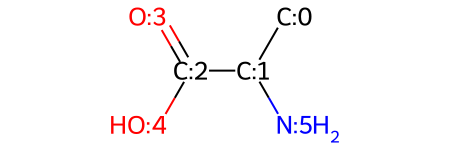

In [78]:
idx = smallest_idx
rec = noisy_set[idx]
smiles = rec.metadata["smiles"]
mol = Chem.MolFromSmiles(smiles)
Chem.Kekulize(mol, clearAromaticFlags=True)

bonds = [b for b in mol.GetBonds()]

for i, atom in enumerate(mol.GetAtoms()):
    atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))

print(len(bonds))
mol

In [76]:
for b in bonds:
    
    b1 = b.GetIdx()

    for b in bonds:

        b2 = b.GetIdx()

        if b2 <= b1: continue 
            
        frag_mol = Chem.FragmentOnBonds(mol, [b1])
        frags = Chem.GetMolFrags(frag_mol, asMols=True, sanitizeFrags=True)

        # print(bonds[b.GetIdx()].GetBeginAtom().GetSymbol(), bonds[b].GetEndAtom().GetSymbol())
        
        # Calculate mass of each fragment
        for i, frag in enumerate(frags):
            mass = Descriptors.ExactMolWt(frag)
            mass_loss_H = mass - 1.0078
            smiles_frag = Chem.MolToSmiles(frag)  # Get SMILES for the fragment (optional)
            print(f"{i+1}: SMILES = {smiles_frag}, Mass = {mass:.4f} Da, Mass without H = {mass_loss_H:.4f}")

        print()

# (42.0333, 0.0055000000000000005)
# (43.0393, 0.0073)
# (44.0484, 1.0)
# (44.077, 0.05)
# (44.2029, 0.003)
# (44.2561, 0.003)
# (44.4615, 0.003)
# (44.58, 0.0037)
# (44.9963, 0.0208)

1: SMILES = [1*]C, Mass = 15.0235 Da, Mass without H = 14.0157
2: SMILES = *C(N)C(=O)O, Mass = 74.0242 Da, Mass without H = 73.0164

1: SMILES = [1*]C, Mass = 15.0235 Da, Mass without H = 14.0157
2: SMILES = *C(N)C(=O)O, Mass = 74.0242 Da, Mass without H = 73.0164

1: SMILES = [1*]C, Mass = 15.0235 Da, Mass without H = 14.0157
2: SMILES = *C(N)C(=O)O, Mass = 74.0242 Da, Mass without H = 73.0164

1: SMILES = [1*]C, Mass = 15.0235 Da, Mass without H = 14.0157
2: SMILES = *C(N)C(=O)O, Mass = 74.0242 Da, Mass without H = 73.0164

1: SMILES = [2*]C(C)N, Mass = 44.0500 Da, Mass without H = 43.0422
2: SMILES = [1*]C(=O)O, Mass = 44.9977 Da, Mass without H = 43.9899

1: SMILES = [2*]C(C)N, Mass = 44.0500 Da, Mass without H = 43.0422
2: SMILES = [1*]C(=O)O, Mass = 44.9977 Da, Mass without H = 43.9899

1: SMILES = [2*]C(C)N, Mass = 44.0500 Da, Mass without H = 43.0422
2: SMILES = [1*]C(=O)O, Mass = 44.9977 Da, Mass without H = 43.9899

1: SMILES = [3*]=C(O)C(C)N, Mass = 73.0528 Da, Mass without 

In [58]:
inchikey = rec.metadata["inchikey"]
instrument = rec.metadata["instrument_type"]
adduct = rec.metadata["adduct"]
energy = rec.metadata["collision_energy"]

cand = DB_formatted[inchikey][instrument][adduct][energy]
cand = [c for c in cand if c.metadata["identifier"] != rec.metadata["identifier"]]

print("noise", instrument, energy)
print(rec.metadata["identifier"])

for p in list(zip(rec.mz, rec.intensities)):
    print(p)

print()

print("Candidates")
for c in cand:

    print(c.metadata["identifier"], c.metadata["instrument_type"], c.metadata["collision_energy"])
    for p in list(zip(c.mz, c.intensities)):
        # if p[1] < 0.02: continue
        print(p)
    
    print()

noise QTOF 20.0
MassSpecGymID0171928
(42.0333, 0.0055000000000000005)
(43.0393, 0.0073)
(44.0484, 1.0)
(44.077, 0.05)
(44.2029, 0.003)
(44.2561, 0.003)
(44.4615, 0.003)
(44.58, 0.0037)
(44.9963, 0.0208)

Candidates
MassSpecGymID0065018 QTOF 20.0
(55.0174, 0.7957957957957958)
(90.0545, 1.0)

MassSpecGymID0065019 QTOF 20.0
(55.0174, 0.7962963000000001)
(90.0545, 1.0)

MassSpecGymID0065025 QTOF 20.0
(42.03657, 0.031)
(42.05032, 0.012)
(44.0508, 1.0)
(44.05951, 0.43200000000000005)
(44.08607, 0.019)
(44.24367, 0.006)
(44.88856, 0.005)
(45.00906, 0.040999999999999995)

MassSpecGymID0065027 QTOF 20.0
(42.04448, 0.017)
(44.05073, 1.0)
(44.05993, 0.344)
(44.08636, 0.023)
(44.10279, 0.006)
(44.16563, 0.006)
(44.99873, 0.033)
(45.01067, 0.006999999999999999)
(72.08089, 0.006999999999999999)

MassSpecGymID0065032 QTOF 20.0
(44.04884, 1.0)
(44.07464, 0.032)
(44.99579, 0.016)
(57.93492, 0.006)
(68.95068, 0.008)
(72.93639, 0.011000000000000001)
(81.93741, 0.023)

MassSpecGymID0065034 QTOF 20.0
(44.0

Plot the MS

<Figure size 1400x700 with 0 Axes>

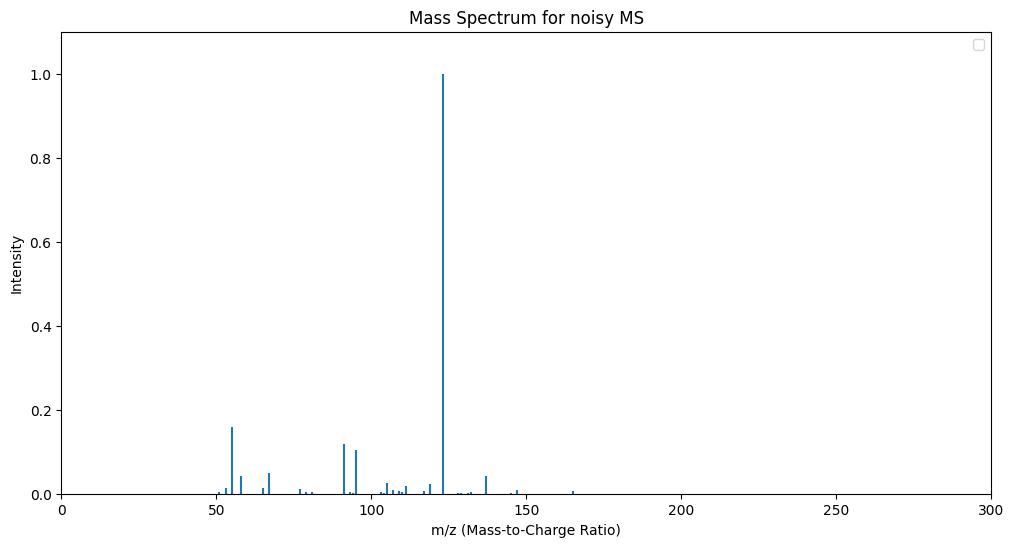

<Figure size 1400x700 with 0 Axes>

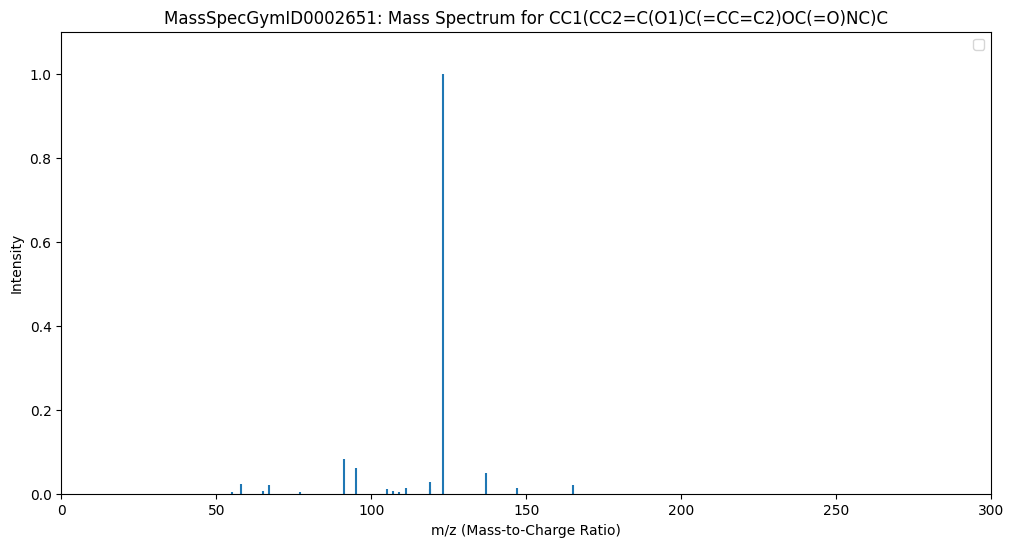

<Figure size 1400x700 with 0 Axes>

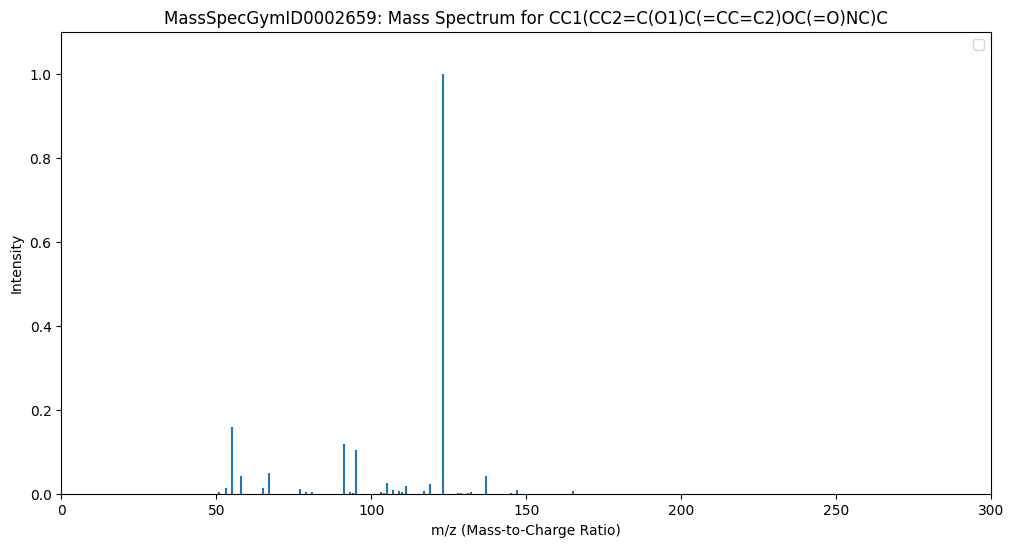

<Figure size 1400x700 with 0 Axes>

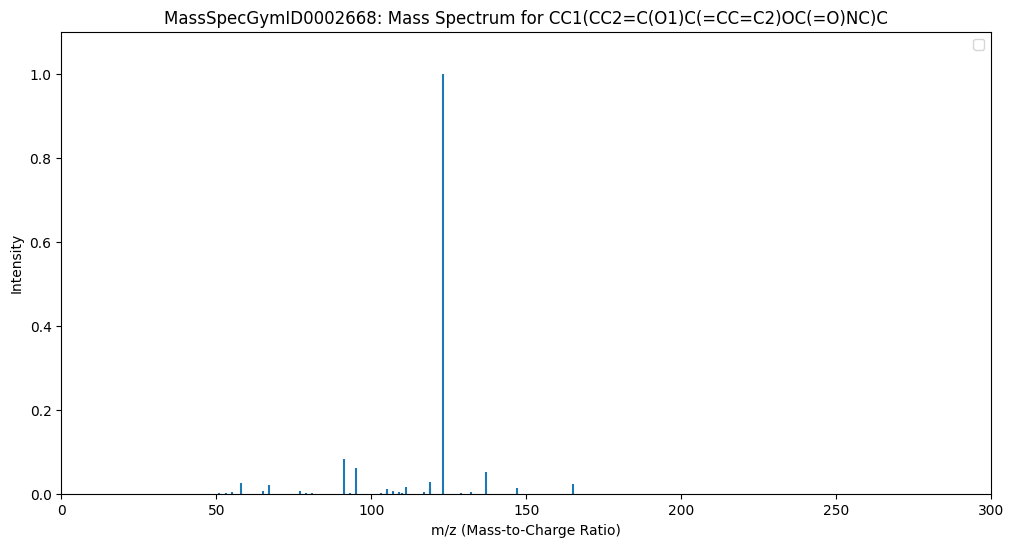

In [100]:
inchikey = rec.metadata["inchikey"]
instrument = rec.metadata["instrument_type"]
adduct = rec.metadata["adduct"]
energy = rec.metadata["collision_energy"]

# Create the plot
# Create the plot
plt.figure(figsize=(14, 7))

# Create the plot
plt.figure(figsize=(12, 6))
for mz, intensity in zip(rec.mz, rec.intensities):
    plt.vlines(x=mz, ymin=0, ymax=intensity, linewidth=1.5)

# Add labels, title, and grid

plt.ylim(0, 1.1)
plt.xlim(0, 300)
plt.xlabel("m/z (Mass-to-Charge Ratio)")
plt.ylabel("Intensity")
plt.title(f"Mass Spectrum for noisy MS")
plt.legend()
plt.show()


cand = DB_formatted[inchikey][instrument][adduct][energy]

for c in cand:

    id_ = c.metadata["identifier"]
    smiles = c.metadata["smiles"]
    precursor_mz = c.metadata["precursor_mz"]
    mz_values = c.mz
    intensity_values = c.intensities

    # Create the plot
    # Create the plot
    plt.figure(figsize=(14, 7))

    # Create the plot
    plt.figure(figsize=(12, 6))
    for mz, intensity in zip(mz_values, intensity_values):
        plt.vlines(x=mz, ymin=0, ymax=intensity, linewidth=1.5)

    # Add labels, title, and grid
    
    plt.ylim(0, 1.1)
    plt.xlim(0, 300)
    plt.xlabel("m/z (Mass-to-Charge Ratio)")
    plt.ylabel("Intensity")
    plt.title(f"{id_}: Mass Spectrum for {smiles}")
    plt.legend()
    plt.show()


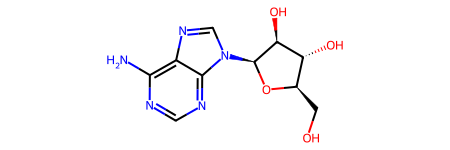

In [59]:
mol = Chem.MolFromSmiles(smiles)
formula = rdMolDescriptors.CalcMolFormula(mol)
mol

In [65]:
print(noisy_set[3].mz)
print(noisy_set[3].intensities)


[ 43.017776  45.03334   45.98716   46.994946  55.017738  57.033306
  61.01054   62.018314  69.03334   71.048988  73.028236  85.028198
  99.043877 110.034775 115.039154 117.054565 128.045578 135.030289
 136.037231 136.042206 136.061768 136.07074  136.080612 136.086411
 136.093323 152.027969 152.033722 152.056824 152.079834 152.085907
 153.040894 178.95816  179.965805 189.950546 207.961243 268.105621]
[0.00243 0.00265 0.00173 0.00245 0.00194 0.00391 0.00259 0.05132 0.00224
 0.00365 0.00567 0.00218 0.00793 0.00497 0.00173 0.01869 0.00332 0.00609
 0.00524 0.00398 1.      0.02039 0.00635 0.00786 0.00292 0.00378 0.00317
 0.59602 0.00329 0.00475 0.02146 0.00435 0.00408 0.00334 0.00948 0.00408]


In [ ]:

for c in cand:

    id_ = c.metadata["identifier"]
    smiles = c.metadata["smiles"]
    precursor_mz = c.metadata["precursor_mz"]
    mz_values = c.mz
    intensity_values = c.intensities
    print(mz_values)
    print()
    

[ 73.0284  85.0284 115.039  119.0349 133.0496 136.0618 268.104 ]

[ 73.0284  85.0284 115.039  119.0349 133.0496 136.0618 268.104 ]

[ 45.987137  46.994911  57.03339   61.010445  62.01833   62.022041
  79.021042  85.028053 136.061737 136.071289 136.080673 136.086166
 136.093369 145.948151 178.957809 179.965927 189.950348 207.960983
 268.104004]

[ 45.987263  46.99501   55.017818  57.033459  61.010593  62.018375
  69.033554  73.028259  85.02832  115.038879 136.037079 136.042114
 136.061783 136.070786 136.080826 136.086105 136.093445 136.100128
 178.958206 179.966187 189.950836 207.96138  268.105225]

